<a href="https://colab.research.google.com/github/Sidy3143/Generative-ai/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries
This cell imports the necessary libraries for building and training a convolutional autoencoder using PyTorch, and for visualizing the latent space using t-SNE.

In [ ]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Import TSNE
This cell imports the `TSNE` class from scikit-learn, which is used for dimensionality reduction to visualize high-dimensional data in a lower-dimensional space.

In [ ]:
from sklearn.manifold import TSNE

### Load and Prepare Data
This cell loads the MNIST dataset, defines a transformation to convert the images to tensors, and creates a DataLoader for iterating through the dataset in batches. The dataset is downloaded if not already present.

In [ ]:
transform = transforms.ToTensor()

mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform = transform)

dataloader = torch.utils.data.DataLoader(dataset =mnist_data, batch_size =64, shuffle =True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 2.87MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Display Sample Image
This cell retrieves a batch of images and labels from the dataloader, extracts the first image, and displays it using Matplotlib to visualize a sample from the dataset.

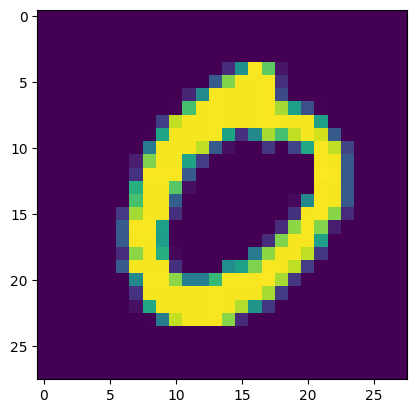

In [ ]:
dataiter = iter(dataloader)
images, labels = next(dataiter)
images = torch.squeeze(images)
plt.imshow(images[0])

### Define Linear Autoencoder
This cell defines a `LinearAutoencoder` class, which is a neural network with fully connected layers for encoding and decoding. The encoder reduces the input to a 5-dimensional latent space, and the decoder reconstructs the input from the latent space.

In [ ]:
class LinearAutoencoder(nn.Module):
  def __init__(self):
    super(LinearAutoencoder, self).__init__()

    self.encoder = nn.Sequential(
        nn.Linear(784, 256),
        nn.ReLU(),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 32),
        nn.ReLU(),
        nn.Linear(32, 5)
    )

    self.decoder = nn.Sequential(
        nn.Linear(5, 32),
        nn.ReLU(),
        nn.Linear(32, 128),
        nn.ReLU(),
        nn.Linear(128, 256),
        nn.ReLU(),
        nn.Linear(256, 784),
        nn.Sigmoid()
    )

  def forward(self, x):
    latent_space = self.encoder(x)
    reconstructed = self.decoder(latent_space)

    return reconstructed

### Define Convolutional Autoencoder
This cell defines a `ConvAutoencoder` class, which is a neural network with convolutional and transpose convolutional layers for encoding and decoding images. The encoder reduces the input image to a latent space, and the decoder reconstructs the image from the latent space.

In [ ]:
class ConvAutoencoder(nn.Module):
  def __init__(self):
    super(ConvAutoencoder, self).__init__()

    self.encoder = nn.Sequential(  # start with 28,28
        nn.Conv2d(1, 16, 3, stride=2, padding=1), # 14, 14
        nn.ReLU(),
        nn.Conv2d(16, 32, 3, stride=2, padding=1), # 7, 7
        nn.ReLU(),
        nn.Conv2d(32, 64, 7, stride=2) # 1, 1
    )
    self.decoder = nn.Sequential( # start with 1, 1
        nn.ConvTranspose2d(64, 32, 7, stride=2), # 7, 7
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1), # 14, 14
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1) # 28, 28
    )

  def forward(self, x):
      latent_space = self.encoder(x)
      recon = self.decoder(latent_space)

      return recon, latent_space

### Set Device
This cell checks if a CUDA-enabled GPU is available and sets the device to 'cuda' if it is, otherwise it sets the device to 'cpu'. A cpu might be enough for this example.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
device

device(type='cuda')

### Initialize Model, Loss Function, and Optimizer
This cell initializes the `ConvAutoencoder` model, moves it to the selected device (GPU or CPU), defines the Mean Squared Error (MSE) as the loss function, and sets up the Adam optimizer for updating the model's weights during training.

In [ ]:
model = ConvAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

### Training Loop
This cell contains the training loop for the convolutional autoencoder. It iterates through the specified number of epochs, processes the data in batches, performs the forward and backward passes, calculates the loss, and updates the model's parameters using the optimizer. The loss is printed at the end of each epoch.

In [ ]:
#trainning loop
epochs = 5
outputs = []
for i in range(epochs):
  for img, _ in dataloader:
    #img = img.reshape(-1, 28*28) # 64, 784
    img = img.to(device)

    recon_images, _ = model(img) # 64, 784
    loss = criterion(img, recon_images)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print(f"epoch: , {i}, loss: {loss.item():.4f}")
  outputs.append((i, img, recon_images)) # 10 of (64, 784) for images

epoch: , 0, loss: 0.0080
epoch: , 1, loss: 0.0055
epoch: , 2, loss: 0.0040
epoch: , 3, loss: 0.0043
epoch: , 4, loss: 0.0032


### Visualize Latent Space (3D t-SNE)
This cell visualizes the latent space learned by the autoencoder using 3D t-SNE. It takes a random sample of data, obtains their latent representations from the trained encoder, applies t-SNE to reduce the dimensionality to 3, and plots the 3D latent space with points colored by their corresponding labels.

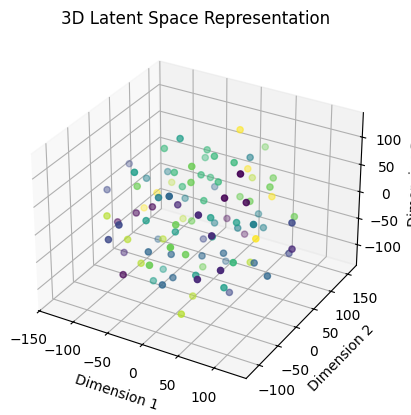

In [ ]:
import numpy as np
import random

from mpl_toolkits.mplot3d import Axes3D

# Project to 3D using t-SNE
tsne = TSNE(n_components=3, random_state=42)  # Change n_components to 3
latent_3d = tsne.fit_transform(latent_representations)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot the latent representations in 3D
ax.scatter(latent_3d[:, 0], latent_3d[:, 1], latent_3d[:, 2], c=all_labels)

# Add labels and title
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
ax.set_title('3D Latent Space Representation')

plt.show()

### Latent Space Shape
This cell prints the shape of the latent space output from the encoder for a batch of data.

In [ ]:
latent.shape

torch.Size([32, 64, 1, 1])

### Image Shape
This cell prints the shape of the input images.

In [ ]:
print(img.shape)

torch.Size([32, 1, 28, 28])


### Number of Epochs
This cell prints the total number of epochs the model was trained for.

In [ ]:
print(len(outputs))

5


### Plot Original and Reconstructed Images
This cell visualizes a comparison between the original input images and their corresponding reconstructed images from the autoencoder's output for the first 10 epochs. It displays 5 pairs of original and reconstructed images per epoch.

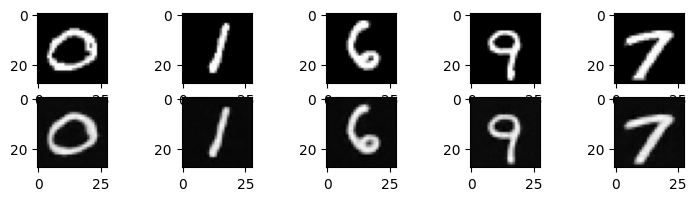

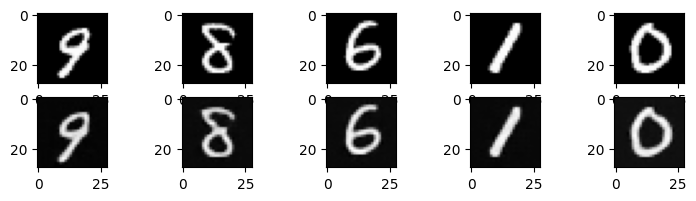

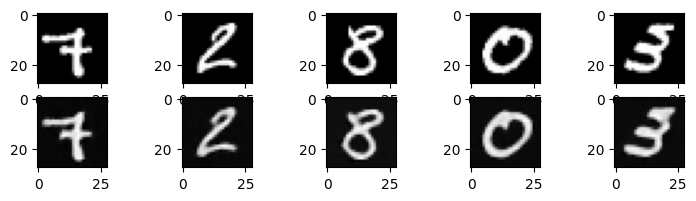

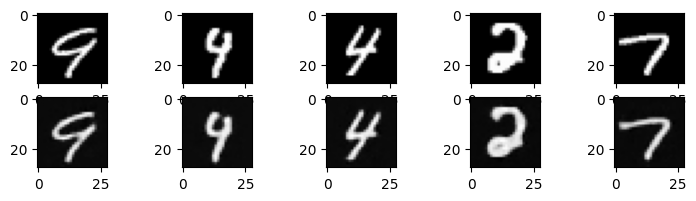

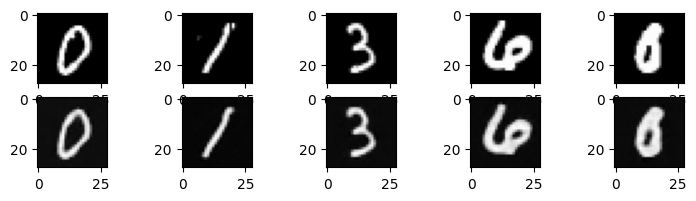

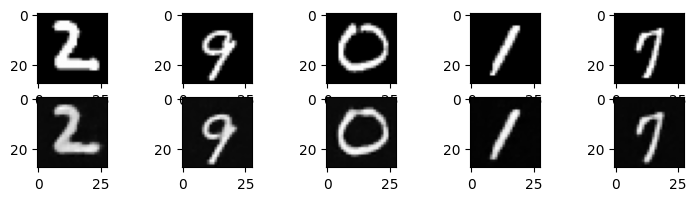

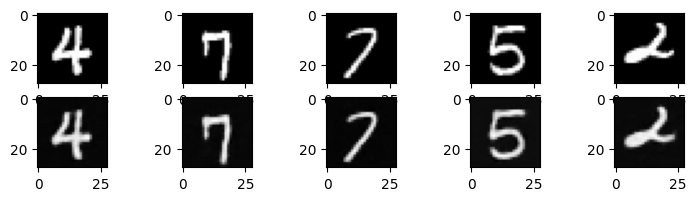

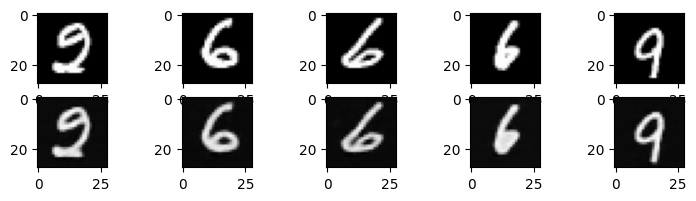

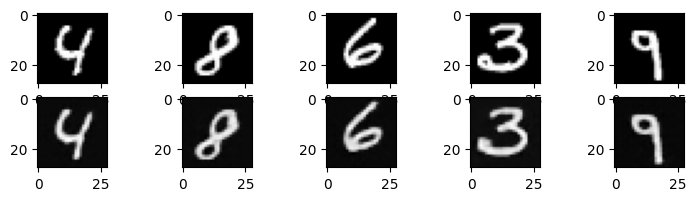

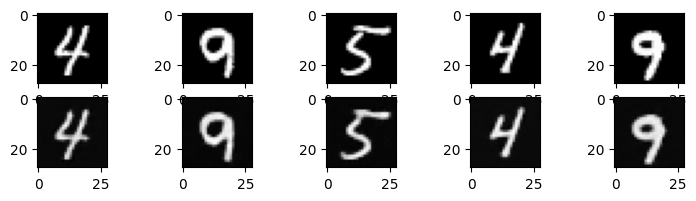

In [ ]:
# plot images for epochs
for n in range(10):
  plt.figure(figsize=(9, 2))

  images = outputs[n][1][:5].cpu().detach().numpy()
  recon_images = outputs[n][2][:5].cpu().detach().numpy()


  for i in range(5):
    real_img = images[i].squeeze()
    plt.subplot(2, 5, i+1)
    plt.imshow(real_img, cmap="gray")

  for j in range(5):
    recon_img = recon_images[j].squeeze()
    plt.subplot(2, 5, 5+j+1)
    plt.imshow(recon_img, cmap="gray")
plt.show()